# Using Xarray with NetCDF and DAP4

This notebook contains a simple example of how to use Xarray with the NetCDF Python interface and DAP4 to pull data from remote DAP4 servers into your Python program's memory space so that the data may be analyized and displayed.

The Xarray paclage "makes working with labelled multi-dimensional arrays in Python simple, efficient, and fun!"

This tutorial utilizes the NASA Global High Resolution Sea Surface Temperature from the GOES-16 satellite. You may wish to review the summary on our Tutorial Datasets page before continuing.

To read more about this package, see __[Xarray](https://docs.xarray.dev/en/stable/index.html)__ and __[netCDF4](https://unidata.github.io/netcdf4-python/)__ which both include information on OPeNDAP.

You can run this tutorial in your browser using Binder.<br>

[<img src="https://mybinder.org/badge_logo.svg" 
     align="left"/>](https://mybinder.org/v2/gh/OPENDAP/NASA-tutorials/HEAD?labpath=%2Ftutorials%2F2.xarray_netcdf_tutorial.ipynb)

<br>

### Contents
[Imports](#What-you-need-to-import) Packages you need to read data from the OPeNDAP server<br>
[Opening the remote dataset](#Open-the-remote-dataset-using-the-URL) The initial interaction with the remote dataset<br>
[Looking at a variable](#Looking-at-a-variable) Get attribute information about a specific variable<br>
[Getting useful information about variables](#Getting-useful-information-a-variable) More about variables<br>
[Accessing data](#Accessing-data) Read values in the arrays<br>
[Plotting data](#Plotting-data) This section imports some more packages<br>
[References](#References)<br>

Copyright (C) 2023 OPeNDAP, Inc. This Jupyter Notebook is made available under the Creative Commons Attribution license 4.0.


## What you need to import

To use the netCDF4 Python package to read from OPeNDAP servers, including the NASA Cloud-based server, you only need to include the `netCDF4` package. Later in this notebook we will show some plots that use other packages for the graphics.

In [ ]:
# Use pip3 to install netCDF4 until conda has a version that authenticates with EDL.
# For xarray, install netCDF4 explicitly since the default netCDF4 version will fail
# to properly apply the CF scale_factor attribute.

!pip3 --quiet install netcdf4
!pip3 --quiet install xarray

import xarray as xr
import numpy as np    # Note strictly needed since xarray imports this, but added for completeness

### Tutorial configuration

Set the variables below to switch between data served using the NASA Cloud-based server and the OPeNDAP test server and to toggle verbose output mode.
By default we will use data served from our test server since that does not require authentication. If you want to see those same data from the NASA server
you will need to obtain credentials for NASA's __[Earthdata Login](https://urs.earthdata.nasa.gov/)__ and for the (simple) steps to
__[configure netCDF4](https://opendap.github.io/documentation/tutorials/ClientAuthentication_at.html#_matlab_ferret_other_applications_that_use_netcdf_c)__
to use those.

<div class="alert alert-block alert-info">
    Be sure to start the URL with the <b><tt>dap4:</tt></b> prefix and not the <b><tt>https:</tt></b>
    prefix when using <b>Xarray</b> with the <b>netCDF4 Python</b> package and accessing data served by 
    NASA's OPeNDAP in the Cloud server. The OPeNDAP in the Cloud server will otherwise 
    send responses that (often) cannot represent some of the variables in the dataset.
</div>

In [2]:
USE_NASA_CLOUD_BASED_DATA = True

VERBOSE = True

# Detect authentication has already happened. This is easy to override.
ALREADY_AUTH = False
import subprocess

if(USE_NASA_CLOUD_BASED_DATA):
    print(f"The netCDF4 library version must be 4.9.0 or be >= 4.9.3 for EDL authentication to work.")
    # print(f"The netCDF4 library version is {nc4.getlibversion()}")

    import earthaccess
    auth = earthaccess.login(strategy="interactive", persist=True)
    subprocess.call(['bash', '../setup_dodsrc.sh'])
    
    dataset_url = "dap4://opendap.earthdata.nasa.gov/collections/C2036877806-POCLOUD/granules/20220812010000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20220812_010000-v02.0-fv01.0"
else:
    dataset_url = "dap4://test.opendap.org/opendap/tutorials/20220812010000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20220812_010000-v02.0-fv01.0.nc"

# define 'vprint()'' as print() if VERBOSE is True, otherwise define it as a function that does nothing.
vprint = print if VERBOSE else lambda *a, **k: None

vprint(f"dataset_url: {dataset_url}")

Are you authenticated... yes.
The netCDF4 library version must be 4.9.0 or be >= 4.9.3 for EDL authentication to work.
dataset_url: dap4://opendap.earthdata.nasa.gov/collections/C2036877806-POCLOUD/granules/20220812010000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20220812_010000-v02.0-fv01.0


## Open the remote dataset using the URL

When a URL is passed to the xarray.open_dataset() function, there is a delay as the information about this dataset is read from the remote site. The delay in opening a remote dataset using xarray with the netCDF backend (the default) is proportional to the total size of the dataset. In other tutorials, we will explore ways to reduce this initial wait. 

If the returned <em>Xarray Dataset</em> object (<em>remote_data</em> in this example) is printed, we can see that information that includes the data model, file format and dataset attributes. The Xarray Dataset object has a particularly nice presentation, so we show that here. It can also be printed using the python <em>print()</em> function.

The variables' names are used to access the values (shown later).

In [3]:
%%time

remote_data = xr.open_dataset(dataset_url)

# Instead of using print(), let's use xarray's built-in preint representation

remote_data

CPU times: user 1.24 s, sys: 195 ms, total: 1.44 s
Wall time: 15.5 s


<xarray.Dataset>
Dimensions:                    (time: 1, lat: 2400, lon: 2400)
Coordinates:
  * lon                        (lon) float32 -135.0 -134.9 ... -15.07 -15.02
  * time                       (time) datetime64[ns] 2022-08-12T01:00:00
  * lat                        (lat) float32 -59.97 -59.92 ... 59.92 59.97
Data variables: (12/16)
    wind_speed                 (time, lat, lon) float32 ...
    or_longitude               (time, lat, lon) float32 ...
    sses_standard_deviation    (time, lat, lon) float32 ...
    sst_dtime                  (time, lat, lon) timedelta64[ns] ...
    solar_zenith_angle         (time, lat, lon) float32 ...
    sea_ice_fraction           (time, lat, lon) float32 ...
    ...                         ...
    quality_level              (time, lat, lon) float32 ...
    dt_analysis                (time, lat, lon) float32 ...
    satellite_zenith_angle     (time, lat, lon) float32 ...
    adi_dtime_from_sst         (time, lat, lon) float32 ...
    or_latitude                (time, lat, lon) float32 ...
    sses_bias                  (time, lat, lon) float32 ...
Attributes: (12/48)
    Conventions:                CF-1.4
    title:                      Sea Surface Temperature
    summary:                    The L3C product derived from GOES16/ABI brigh...
    references:                 Geostationary Sea Surface Temperature Product...
    institution:                OSISAF
    comment:                    
    ...                         ...
    date_created:               20220812T015542Z
    start_time:                 20220812T004042Z
    time_coverage_start:        20220812T004042Z
    stop_time:                  20220812T011929Z
    time_coverage_end:          20220812T011929Z
    netcdf_version_id:          4.6.3

## Looking at a variable

Because information about each variable was read during the xarray.open_dataset() call, the response for examining information for each variable is fast. We can click on the triangle next to 'Data variables:' above and see the name, dimensions and datatype of each variable in the data set. Use that name as an index into the remote_datga object.

The Dataset object retruend by the xarray.open_dataset() method is a collection similar to a python dictionary "of DataArray objects with aligned dimensions." Each named element is a <em>DataArray</em>. See the __[terminology](https://docs.xarray.dev/en/stable/user-guide/terminology.html)__ section of the Xarray documentation for more information. 

Let's look at the Sea Surface Temperature variable (i.e., <em>sea_surface_temperature</em>). As with the object returned by open_dataset(), the object returned when accessing remote_data['sea_surface_temperature'] has a very nice print representation.

In [4]:
%%time

SST = remote_data['sea_surface_temperature'][::1,::1,::1]

SST    # Use the DataArray object print representation

CPU times: user 709 µs, sys: 41 µs, total: 750 µs
Wall time: 756 µs


<xarray.DataArray 'sea_surface_temperature' (time: 1, lat: 2400, lon: 2400)>
[5760000 values with dtype=float32]
Coordinates:
  * lon      (lon) float32 -135.0 -134.9 -134.9 -134.8 ... -15.12 -15.07 -15.02
  * time     (time) datetime64[ns] 2022-08-12T01:00:00
  * lat      (lat) float32 -59.97 -59.92 -59.88 -59.83 ... 59.88 59.92 59.97
Attributes:
    long_name:      sea surface subskin temperature
    standard_name:  sea_surface_subskin_temperature
    units:          kelvin
    valid_min:      -300
    valid_max:      4500
    depth:          1 millimeter
    source:         GOES_Imager
    comment:        Temperature of the subskin of the ocean

## Getting useful information a variable

With Xarray, the DataArray object returned by remote_data[<em>variable name</em>] can be used to examine information about the variable. There is a bit more information about the variable than is imediately available with the netCDF API. For example, the 'Coordiantes:' information includes the begining and ending values of those arrays. 

Also included in the DataArray print rep is information about each of the variable's Attributes. This is where important <em>use metadata</em> can often be found.

In [5]:
SST

<xarray.DataArray 'sea_surface_temperature' (time: 1, lat: 2400, lon: 2400)>
[5760000 values with dtype=float32]
Coordinates:
  * lon      (lon) float32 -135.0 -134.9 -134.9 -134.8 ... -15.12 -15.07 -15.02
  * time     (time) datetime64[ns] 2022-08-12T01:00:00
  * lat      (lat) float32 -59.97 -59.92 -59.88 -59.83 ... 59.88 59.92 59.97
Attributes:
    long_name:      sea surface subskin temperature
    standard_name:  sea_surface_subskin_temperature
    units:          kelvin
    valid_min:      -300
    valid_max:      4500
    depth:          1 millimeter
    source:         GOES_Imager
    comment:        Temperature of the subskin of the ocean

## Accessing data

The DataArray object has methods/accessors that return all raw data, attributes, etc. The following cells show some examples. Most important is the `values` accessor that returns a <em>numpy</em> array object that can be used with many other packages. Here is how to access that object:

In [6]:
SST.values

array([[[   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        ...,
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ..., 288.28, 288.28, 288.28],
        [   nan,    nan,    nan, ..., 286.6 , 286.6 ,    nan]]],
      dtype=float32)

### Other information in the DataArry object
You can access the Attributes, Dimensions and Coordinates using the `attrs`, `dims`, and `coords` accessors. These
accessors return the same information as in the special print representation, but using Python data structures that
can be passed to Python code.

See __[Data Structures](https://docs.xarray.dev/en/stable/user-guide/data-structures.html)__ in teh Xarray
documentation for more details.

In [7]:
SST.attrs

{'long_name': 'sea surface subskin temperature',
 'standard_name': 'sea_surface_subskin_temperature',
 'units': 'kelvin',
 'valid_min': -300,
 'valid_max': 4500,
 'depth': '1 millimeter',
 'source': 'GOES_Imager',
 'comment': 'Temperature of the subskin of the ocean'}

In [8]:
SST.dims

('time', 'lat', 'lon')

In [9]:
SST.coords

Coordinates:
  * lon      (lon) float32 -135.0 -134.9 -134.9 -134.8 ... -15.12 -15.07 -15.02
  * time     (time) datetime64[ns] 2022-08-12T01:00:00
  * lat      (lat) float32 -59.97 -59.92 -59.88 -59.83 ... 59.88 59.92 59.97

## Plotting data

Xarray has extensive support for plotting data - much more than we will cover here. However, the simple `plot()` method of the DataArray is very useful. Compare its output below to that of the netCDF4 notebook. The Xarray `plot()` method provides axis labels, color bar, converts the axis labels to the coordinate variables and their values, etc., all automatically.

Using `matplotlib` and `cartopy` in conjunction with xarray, these plots can be customized to different projections, include coastlines and more See __[Plotting - Maps](https://docs.xarray.dev/en/stable/user-guide/plotting.html#maps)__.

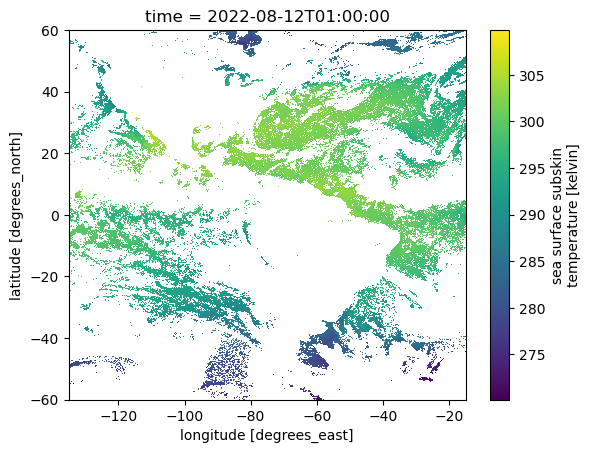

In [10]:
SST.plot()

### Let's revisit the plots from the simple netCDF4 notebook, this time using data read by xarray
The default plot produced by xarray is great, but we can also replicate the plots from the earlier 
netCDF4 notebook for completeness sake.

In [11]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker

# import numpy as np     # Not strickly needed since netCDF4 includes numpy. Added for completeness.

### Adding coastlines

Here is a fancier plot (albeit without the color bar). While the simplest plot used `matplotlib` directly, this plot uses an `axes` object from `matplotlib` to set a projection, plot the data and add coastlines.

/Users/jimg/opt/miniforge3/envs/nasa-local/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


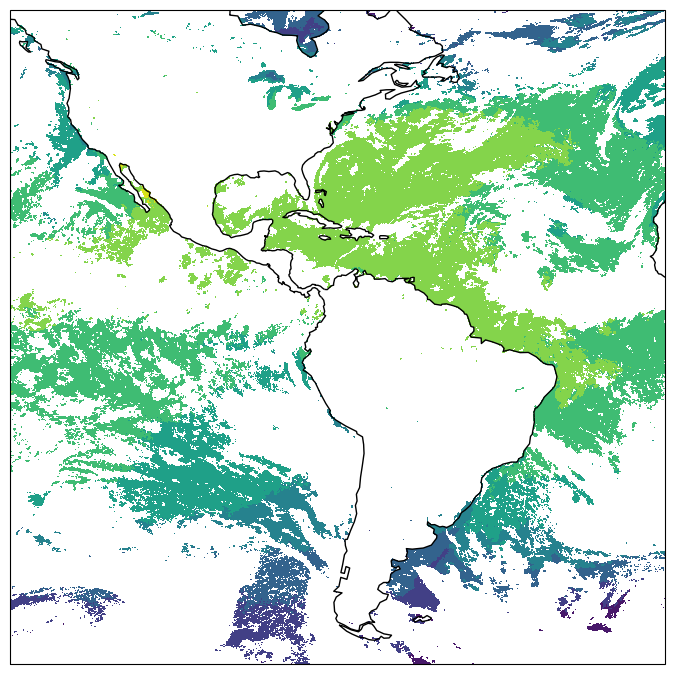

In [12]:
# Make the figure larger
fig = plt.figure(figsize=(11,8.5))

# Set the axes using the specified map projection
ax = plt.axes(projection=ccrs.PlateCarree())

sst = np.squeeze(SST.values)
longitude = SST.coords['lon'].values
latitude = SST.coords['lat'].values

# Make a filled contour plot
ax.contourf(longitude, latitude, sst, transform = ccrs.PlateCarree())

# Add coastlines
ax.coastlines()

### Improving on the 'coastlines added' plot.

In this plot we add latitude and longitude marks, include the color bar, and swap the default color map for one better suited to temperature data. 

Longitude range: -134.97500610351562,-15.024999618530273
Longitude end points: -130,-10
Latitudde range: -59.974998474121094,59.974998474121094
Latitudde end points: -50,60


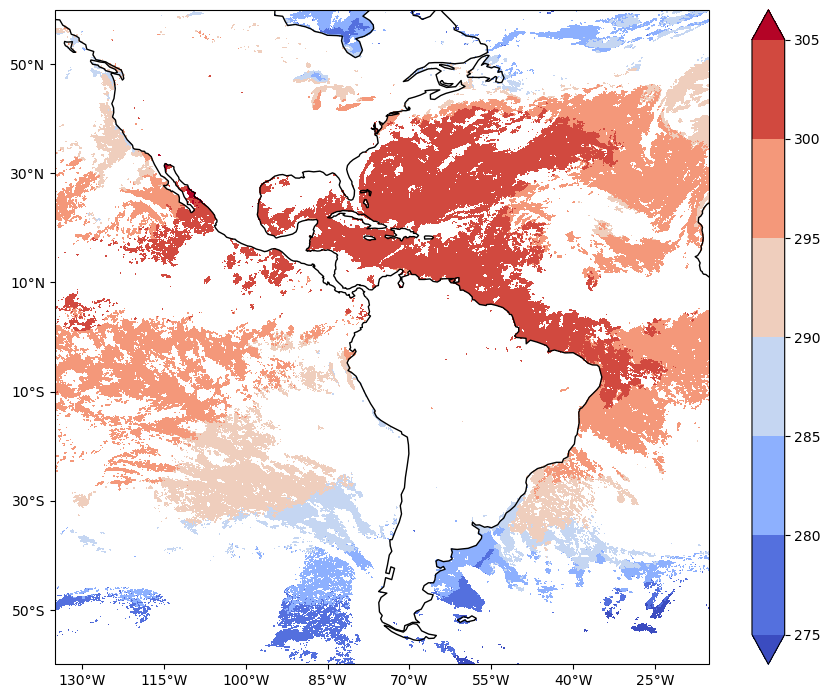

In [13]:
# Make the figure larger
fig = plt.figure(figsize=(11,8.5))

# Set the axes using the specified map projection
ax = plt.axes(projection=ccrs.PlateCarree())

# If these data were cyclic, add cyclic point to data
# data=ds_mean['tas']
# data, lons = add_cyclic_point(data, coord=ds['lon'])

# Make a filled contour plot.
# Chhose a colormap that's more suited to temperature data
# using the 'cmap' option. The extend' option adds arrows on
# the top and bottom of the color bar.
cs = ax.contourf(longitude, latitude, sst, transform = ccrs.PlateCarree(), cmap='coolwarm', extend='both')

# Add coastlines
ax.coastlines()

# For these SST data, set the longitude endpoints for the plot either
# based on examining the real values or computing endpoints using rounding.
# Although we computed the endpoints in this example, it may be  faster 
# to look at the real data end points and choose the plot ranges and 
# tick spacing by hand. The VERBOSE mode is useful in that case.

lon1 =  round((longitude[0]+5)/10)*10
lon2 =  round((longitude[-1]+5)/10)*10

vprint(f'Longitude range: {longitude[0]},{longitude[-1]}')
vprint(f'Longitude end points: {lon1},{lon2}')

lon_tick_spacing = 15

# Define the xticks for longitude
ax.set_xticks(np.arange(lon1, lon2, lon_tick_spacing), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)

lat1 =  round((latitude[0]+5)/10)*10
lat2 =  round((latitude[-1]+5)/10)*10

vprint(f'Latitudde range: {latitude[0]},{latitude[-1]}')
vprint(f'Latitudde end points: {lat1},{lat2}')

lat_tick_spacing = 20

# Define the yticks for latitude
ax.set_yticks(np.arange(lat1, lat2, lat_tick_spacing), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)

# Add colorbar
cbar = plt.colorbar(cs)

## References
Xarray documentation, https://docs.xarray.dev/en/stable/index.html, Accessed 2023-06-26<br>
Welcome to Pangeo at AOES. Making Maps using Cartopy. https://kpegion.github.io/Pangeo-at-AOES/examples/cartopy-tutorial.html<br>
